In [1]:
import pandas as pd

donwload the dataset and put under `data`

## Load user responses

In [2]:
data = pd.read_csv('data/train_data/train_task_3_4.csv')
data.head()

,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue
0,898,2111,280203,1,2,2
1,767,3062,55638,1,3,3
2,165,1156,386475,1,2,2
3,490,1653,997498,1,4,4
4,298,3912,578636,1,3,3


In [3]:
len(data)

1382727

In [4]:
question_data = pd.read_csv('data/metadata/answer_metadata_task_3_4.csv')
question_data.head()

,AnswerId,DateAnswered,Confidence,GroupId,QuizId,SchemeOfWorkId
0,1451945,2019-10-30 14:34:00.000,NaN,4,32,52562.0
1,45325,2020-01-06 18:53:00.000,75.0,185,66,52562.0
2,687013,2020-01-18 10:52:00.000,NaN,235,64,52562.0
3,91254,2020-02-29 17:25:00.000,NaN,194,97,52562.0
4,1225855,2020-03-06 15:07:00.000,NaN,95,115,52562.0


In [5]:
data = data.merge(question_data, on="AnswerId", how="left")
data = data.groupby("QuestionId")[["Confidence", "IsCorrect"]].mean()
data['Confidence'].fillna(value=data['Confidence'].mean(),inplace=True)
data['IsCorrect'].fillna(value=data['IsCorrect'].mean(),inplace=True)
data = data.reset_index()
data.head()

,QuestionId,Confidence,IsCorrect
0,0,66.176471,0.443457
1,1,74.036219,0.571429
2,2,66.201354,0.385214
3,3,85.021246,0.808757
4,4,59.343434,0.401408


In [6]:
# load evaluators' score on "validation" set
eval_validation = pd.read_csv('data/test_data/quality_response_remapped_public.csv')
print(len(eval_validation))
eval_validation.head()

25


,Unnamed: 0.1,Unnamed: 0,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS
0,0,0,909,318,2,2,2,1.0,2
1,16,16,285,609,2,2,2,2.0,2
2,48,48,132,271,1,2,2,2.0,1
3,38,38,704,127,2,2,1,2.0,2
4,33,33,16,586,1,1,2,2.0,2


<Axes: >

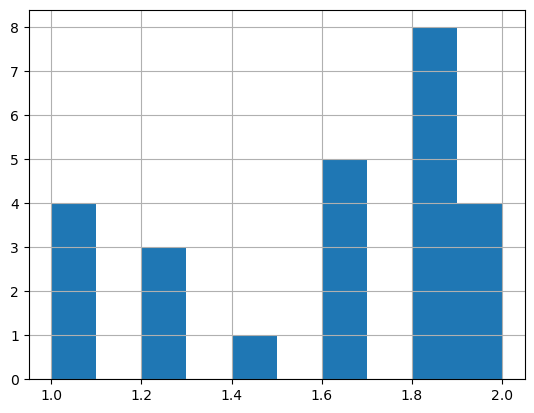

In [7]:
# take the average of 5 evaulators` scores
eval_validation['score'] = eval_validation.filter(regex='^T', axis = 1).mean(axis=1)
eval_validation['score'].hist()

<Axes: >

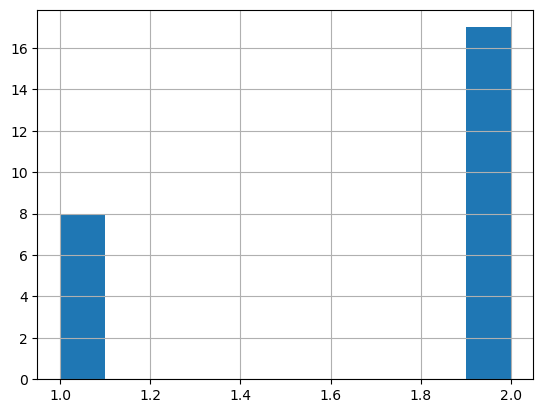

In [8]:
# decide preference
import numpy as np
def calc_preference(scores):
    preference = np.ones(len(scores), dtype=int)

    idx_two = scores > 1.5
    preference[idx_two] = 2
    
    return list(preference)

eval_validation['preference'] = calc_preference(eval_validation['score'])
# eval_dev[]
# eval_dev['score']
eval_validation['preference'].hist()

In [9]:
eval_test = pd.read_csv('data/test_data/quality_response_remapped_private.csv')
print(len(eval_test))
eval_test.head()

25


,Unnamed: 0.1,Unnamed: 0,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS
0,15,15,145,762,2,2,2,2.0,2
1,31,31,307,208,1,1,1,2.0,1
2,25,25,278,195,1,1,1,1.0,1
3,3,3,13,153,2,2,2,2.0,2
4,40,40,23,100,2,1,1,1.0,1


<Axes: >

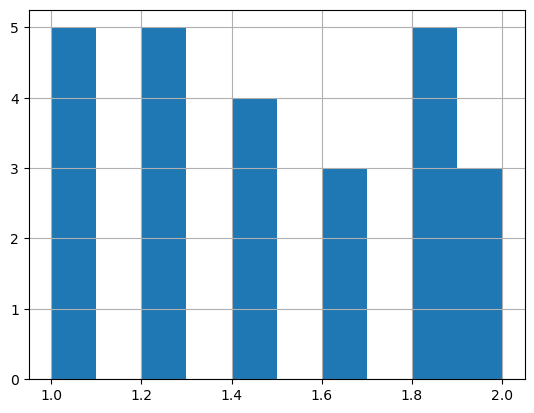

In [10]:
# take the average of scores by 5 evaulators
eval_test['score'] = eval_test.filter(regex='^T', axis = 1).mean(axis=1)
eval_test['score'].hist()

<Axes: >

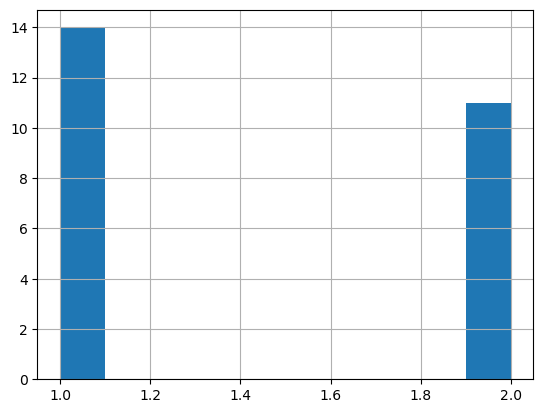

In [11]:
# decide preference
eval_test['preference'] = calc_preference(eval_test['score'])
eval_test['preference'].hist()

## Data preprocessing 

Pre-processing training data

In [12]:
data_training = pd.merge(eval_validation, data, how='left', left_on='left', right_on='QuestionId')
data_training.rename(columns={'IsCorrect':'left_rate'}, inplace=True)
data_training.rename(columns={'Confidence':'left_confidence'}, inplace=True)
data_training = pd.merge(data_training, data, how='left', left_on='right', right_on='QuestionId')
data_training.rename(columns={'IsCorrect':'right_rate'}, inplace=True)
data_training.rename(columns={'Confidence':'right_confidence'}, inplace=True)

data_training.drop(columns={'QuestionId_x', 'QuestionId_y', 'Unnamed: 0.1', 'Unnamed: 0'}, axis=1, inplace=True)
data_training.drop(columns={'T1_ALR', 'T2_CL', 'T3_GF', 'T4_MQ', 'T5_NS', 'score'}, axis=1, inplace=True)
data_training.loc[data_training['preference'] == 1, 'preference'] = 0
data_training.loc[data_training['preference'] == 2, 'preference'] = 1

data_training['left_Interaction'] = data_training['left_confidence']*data_training['left_rate']
data_training['right_Interaction'] = data_training['right_confidence']*data_training['right_rate']

print(len(data_training))
data_training.head()

25


,left,right,preference,left_confidence,left_rate,right_confidence,right_rate,left_Interaction,right_Interaction
0,909,318,1,57.692308,0.530864,59.375000,0.512821,30.626781,30.448718
1,285,609,1,72.151163,0.651419,74.909091,0.452665,47.000630,33.908692
2,132,271,1,73.653846,0.387779,57.352941,0.387486,28.561421,22.223478
3,704,127,1,74.769939,0.577481,81.666667,0.431193,43.178229,35.214067
4,16,586,1,83.974359,0.583478,69.561688,0.246761,48.997213,17.165104


Pre-processing of test data(Private data) to verify model accuracy

In [13]:
data_test = pd.merge(eval_test, data, how='left', left_on='left', right_on='QuestionId')
data_test.rename(columns={'IsCorrect':'left_rate'}, inplace=True)
data_test.rename(columns={'Confidence':'left_confidence'}, inplace=True)
data_test = pd.merge(data_test, data, how='left', left_on='right', right_on='QuestionId')
data_test.rename(columns={'IsCorrect':'right_rate'}, inplace=True)
data_test.rename(columns={'Confidence':'right_confidence'}, inplace=True)

data_test.drop(columns={'QuestionId_x', 'QuestionId_y', 'Unnamed: 0.1', 'Unnamed: 0'}, axis=1, inplace=True)
data_test.drop(columns={'T1_ALR', 'T2_CL', 'T3_GF', 'T4_MQ', 'T5_NS', 'score'}, axis=1, inplace=True)
data_test.loc[data_test['preference'] == 1, 'preference'] = 0
data_test.loc[data_test['preference'] == 2, 'preference'] = 1

data_test['left_Interaction'] = data_test['left_confidence']*data_test['left_rate']
data_test['right_Interaction'] = data_test['right_confidence']*data_test['right_rate']

data_test.head()

,left,right,preference,left_confidence,left_rate,right_confidence,right_rate,left_Interaction,right_Interaction
0,145,762,1,74.806576,0.477912,66.197183,0.286624,35.750934,18.973715
1,307,208,0,59.207161,0.267534,69.444444,0.243590,15.839909,16.915954
2,278,195,0,78.215768,0.541384,81.923077,0.748630,42.344804,61.330040
3,13,153,1,82.876712,0.696585,74.036219,0.750000,57.730641,55.527164
4,23,100,0,67.123288,0.449050,79.545455,0.666667,30.141718,53.030303


## Learn to model

In [14]:
#Utilize the Logistic Regression model to apply to preference (1, 2) 

import statsmodels.api as sm
import statsmodels.formula.api as smf

#using correct rate & confidence
model1 = smf.glm(formula = 'preference ~ left_confidence+left_rate+right_confidence+right_rate+left_Interaction+right_Interaction', 
                data=data_training, family=sm.families.Binomial())
fit1 = model1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             preference   No. Observations:                   25
Model:                            GLM   Df Residuals:                       18
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7.6345
Date:                Sun, 18 Jun 2023   Deviance:                       15.269
Time:                        12:45:55   Pearson chi2:                     20.3
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4743
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            14.4096     44.655      0.323      0.747     -73.112     101.931
left_confidence      -0.1105      0.551     -0.201      0.841      -1.190       0.969
left_rate           -24.5998     87.865     -0.280      0.779    -196.812     147.612
right_confidence     -0.0241      0.632     -0.038      0.970      -1.263       1.215
right_rate           13.9836     94.628      0.148      0.883    -171.484     199.451
left_Interaction      0.3532      1.123      0.314      0.753      -1.849       2.555
right_Interaction    -0.2988      1.232     -0.242      0.808      -2.714       2.117
=====================================================================================
"""

In [16]:
#Confidence determines that the p-value is high and that it is not appropriate
#so it is decided to use only correct rate
model2 = smf.glm(formula = 'preference ~ left_confidence+left_rate+right_confidence+right_rate', 
                data=data_training, family=sm.families.Binomial())
fit2 = model2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             preference   No. Observations:                   25
Model:                            GLM   Df Residuals:                       20
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7.6930
Date:                Sun, 18 Jun 2023   Deviance:                       15.386
Time:                        12:49:14   Pearson chi2:                     21.0
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4718
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           13.0494      9.314      1.401      0.161      -5.205      31.304
left_confidence      0.0561      0.125      0.447      0.655      -0.190       0.302
left_rate            3.0512      6.190      0.493      0.622      -9.082      15.184
right_confidence    -0.1755      0.138     -1.273      0.203      -0.446       0.095
right_rate          -9.2605      6.655     -1.391      0.164     -22.304       3.783
====================================================================================
"""

In [17]:
#left_rate's p-value is also high and that it is not appropriate
#However, it is strange that only one value affects the comparison of the two objects when understood in common sense,
#so I would like to make two models and check them all.
model3 = smf.glm(formula = 'preference ~ right_confidence+right_rate', 
                data=data_training, family=sm.families.Binomial())
fit3 = model3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             preference   No. Observations:                   25
Model:                            GLM   Df Residuals:                       22
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8.0540
Date:                Sun, 18 Jun 2023   Deviance:                       16.108
Time:                        12:49:14   Pearson chi2:                     27.3
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4563
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           17.9033      9.365      1.912      0.056      -0.452      36.259
right_confidence    -0.1541      0.129     -1.194      0.233      -0.407       0.099
right_rate         -10.5338      6.268     -1.681      0.093     -22.818       1.750
====================================================================================
"""

In [18]:
# Learn the training data in Model 1 and check the appropriate probabilities.

Xtrain = sm.add_constant(data_training.loc[:, 'left_confidence':'right_Interaction'])
Ytrain = data_training.preference

prob = fit1.predict(Xtrain)
print("Model 1 in training")

Yhat = 1*(prob>0.3)
print("Probability 0.3 : %f" % np.mean(Ytrain==Yhat))

Yhat = 1*(prob>0.5)
print("Probability 0.5 : %f" % np.mean(Ytrain==Yhat))

Yhat = 1*(prob>0.7)
print("Probability 0.7 : %f" % np.mean(Ytrain==Yhat))

Yhat = 1*(prob>0.9)
print("Probability 0.9 : %f" % np.mean(Ytrain==Yhat))

Model 1 in training
Probability 0.3 : 0.840000
Probability 0.5 : 0.920000
Probability 0.7 : 0.840000
Probability 0.9 : 0.720000


In [19]:
# Learn the training data in Model 2 and check the appropriate probabilities.

Xtrain = sm.add_constant(data_training.loc[:, 'left_confidence':'right_rate'])
Ytrain = data_training.preference

prob = fit2.predict(Xtrain)
print("Model 2 in training")

Yhat = 1*(prob>0.3)
print("Probability 0.3 : %f" % np.mean(Ytrain==Yhat))

Yhat = 1*(prob>0.5)
print("Probability 0.5 : %f" % np.mean(Ytrain==Yhat))

Yhat = 1*(prob>0.7)
print("Probability 0.7 : %f" % np.mean(Ytrain==Yhat))

Yhat = 1*(prob>0.9)
print("Probability 0.9 : %f" % np.mean(Ytrain==Yhat))

Model 2 in training
Probability 0.3 : 0.840000
Probability 0.5 : 0.920000
Probability 0.7 : 0.840000
Probability 0.9 : 0.720000


In [32]:
# Learn the training data in Model 3 and check the appropriate probabilities.

Xtrain = sm.add_constant(data_training.loc[:, 'left_confidence':'right_rate'])
Ytrain = data_training.preference

prob = fit3.predict(Xtrain)
print("Model 3 in training")

Yhat = 1*(prob>0.3)
print("Probability 0.3 : %f" % np.mean(Ytrain==Yhat))

Yhat = 1*(prob>0.5)
print("Probability 0.5 : %f" % np.mean(Ytrain==Yhat))

Yhat = 1*(prob>0.7)
print("Probability 0.7 : %f" % np.mean(Ytrain==Yhat))

Yhat = 1*(prob>0.9)
print("Probability 0.9 : %f" % np.mean(Ytrain==Yhat))

Model 3 in training
Probability 0.3 : 0.800000
Probability 0.5 : 0.920000
Probability 0.7 : 0.880000
Probability 0.9 : 0.680000


In [33]:
# Verifying the probability of Model 1 using test data
Xtest = sm.add_constant(data_test.loc[:, 'left_confidence':'right_Interaction'])
Ytest = data_test.preference

prob_test = fit1.predict(Xtest)
print("Model 1 in test")

Yhat_test = 1*(prob_test>0.3)
print("Probability 0.3 : %f" % np.mean(Ytest==Yhat_test))

Yhat_test = 1*(prob_test>0.5)
print("Probability 0.5 : %f" % np.mean(Ytest==Yhat_test))

Yhat_test = 1*(prob_test>0.7)
print("Probability 0.7 : %f" % np.mean(Ytest==Yhat_test))

Yhat_test = 1*(prob_test>0.8)
print("Probability 0.8 : %f" % np.mean(Ytest==Yhat_test))

Yhat_test = 1*(prob_test>0.9)
print("Probability 0.9 : %f" % np.mean(Ytest==Yhat_test))

Yhat_test = 1*(prob_test>0.95)
print("Probability 0.95 : %f" % np.mean(Ytest==Yhat_test))

Model 1 in test
Probability 0.3 : 0.520000
Probability 0.5 : 0.520000
Probability 0.7 : 0.520000
Probability 0.8 : 0.640000
Probability 0.9 : 0.680000
Probability 0.95 : 0.600000


In [34]:
# Verifying the probability of Model 2 using test data
Xtest = sm.add_constant(data_test.loc[:, 'left_confidence':'right_rate'])
Ytest = data_test.preference

prob_test = fit2.predict(Xtest)
print("Model 2 in test")

Yhat_test = 1*(prob_test>0.3)
print("Probability 0.3 : %f" % np.mean(Ytest==Yhat_test))

Yhat_test = 1*(prob_test>0.5)
print("Probability 0.5 : %f" % np.mean(Ytest==Yhat_test))

Yhat_test = 1*(prob_test>0.7)
print("Probability 0.7 : %f" % np.mean(Ytest==Yhat_test))

Yhat_test = 1*(prob_test>0.8)
print("Probability 0.8 : %f" % np.mean(Ytest==Yhat_test))

Yhat_test = 1*(prob_test>0.9)
print("Probability 0.9 : %f" % np.mean(Ytest==Yhat_test))

Yhat_test = 1*(prob_test>0.95)
print("Probability 0.95 : %f" % np.mean(Ytest==Yhat_test))

Model 2 in test
Probability 0.3 : 0.520000
Probability 0.5 : 0.560000
Probability 0.7 : 0.640000
Probability 0.8 : 0.640000
Probability 0.9 : 0.600000
Probability 0.95 : 0.680000


In [35]:
# Verifying the probability of Model 3 using test data
Xtest = sm.add_constant(data_test.loc[:, 'left_confidence':'right_rate'])
Ytest = data_test.preference

prob_test = fit3.predict(Xtest)
print("Model 3 in test")

Yhat_test = 1*(prob_test>0.3)
print("Probability 0.3 : %f" % np.mean(Ytest==Yhat_test))

Yhat_test = 1*(prob_test>0.5)
print("Probability 0.5 : %f" % np.mean(Ytest==Yhat_test))

Yhat_test = 1*(prob_test>0.7)
print("Probability 0.7 : %f" % np.mean(Ytest==Yhat_test))

Yhat_test = 1*(prob_test>0.8)
print("Probability 0.8 : %f" % np.mean(Ytest==Yhat_test))

Yhat_test = 1*(prob_test>0.9)
print("Probability 0.9 : %f" % np.mean(Ytest==Yhat_test))

Yhat_test = 1*(prob_test>0.95)
print("Probability 0.95 : %f" % np.mean(Ytest==Yhat_test))

Model 3 in test
Probability 0.3 : 0.480000
Probability 0.5 : 0.440000
Probability 0.7 : 0.520000
Probability 0.8 : 0.440000
Probability 0.9 : 0.560000
Probability 0.95 : 0.600000


## To Ranking

In [39]:
Question_data = data[['QuestionId','Confidence','IsCorrect']]
Question_data

,QuestionId,Confidence,IsCorrect
0,0,66.176471,0.443457
1,1,74.036219,0.571429
2,2,66.201354,0.385214
3,3,85.021246,0.808757
4,4,59.343434,0.401408
...,...,...,...
943,943,83.793687,0.566528
944,944,69.852941,0.142857
945,945,72.244733,0.422336
946,946,72.058824,0.459459


In [40]:
#Generate the number of all cases that compare problems
left_Question_data = Question_data.copy()
left_Question_data.rename(columns={'QuestionId' : 'left', 'Confidence' : 'left_confidence', 'IsCorrect':'left_rate'}, inplace=True)
right_Question_data = Question_data.copy()
right_Question_data.rename(columns={'QuestionId' : 'right', 'Confidence' : 'right_confidence', 'IsCorrect':'right_rate'}, inplace=True)

main_data = pd.merge(left_Question_data.assign(key=1), right_Question_data.assign(key=1), on='key').drop('key', axis=1)
main_data.drop(main_data[main_data['left'] == main_data['right']].index, inplace=True)

main_data['left_Interaction'] = main_data['left_confidence']*main_data['left_rate']
main_data['right_Interaction'] = main_data['right_confidence']*main_data['right_rate']

main_data

,left,left_confidence,left_rate,right,right_confidence,right_rate,left_Interaction,right_Interaction
1,0,66.176471,0.443457,1,74.036219,0.571429,29.346394,42.306411
2,0,66.176471,0.443457,2,66.201354,0.385214,29.346394,25.501689
3,0,66.176471,0.443457,3,85.021246,0.808757,29.346394,68.761569
4,0,66.176471,0.443457,4,59.343434,0.401408,29.346394,23.820956
5,0,66.176471,0.443457,5,77.419355,0.190876,29.346394,14.777524
...,...,...,...,...,...,...,...,...
898698,947,75.240385,0.617124,942,73.214286,0.458716,46.432677,33.584535
898699,947,75.240385,0.617124,943,83.793687,0.566528,46.432677,47.471508
898700,947,75.240385,0.617124,944,69.852941,0.142857,46.432677,9.978992
898701,947,75.240385,0.617124,945,72.244733,0.422336,46.432677,30.511575


In [41]:
#The probability is determined to use 0.9
Xresult = sm.add_constant(main_data.loc[:, 'left_confidence':'right_Interaction'])

prob_result = fit1.predict(Xresult)
Yhat_result = 1*(prob_result>0.9)

main_data['preference']=Yhat_result
main_data

,left,left_confidence,left_rate,right,right_confidence,right_rate,left_Interaction,right_Interaction,preference
1,0,66.176471,0.443457,1,74.036219,0.571429,29.346394,42.306411,0
2,0,66.176471,0.443457,2,66.201354,0.385214,29.346394,25.501689,1
3,0,66.176471,0.443457,3,85.021246,0.808757,29.346394,68.761569,0
4,0,66.176471,0.443457,4,59.343434,0.401408,29.346394,23.820956,1
5,0,66.176471,0.443457,5,77.419355,0.190876,29.346394,14.777524,1
...,...,...,...,...,...,...,...,...,...
898698,947,75.240385,0.617124,942,73.214286,0.458716,46.432677,33.584535,0
898699,947,75.240385,0.617124,943,83.793687,0.566528,46.432677,47.471508,0
898700,947,75.240385,0.617124,944,69.852941,0.142857,46.432677,9.978992,1
898701,947,75.240385,0.617124,945,72.244733,0.422336,46.432677,30.511575,1


In [42]:
#Create a group around 'left Question'
#so that the sum of the preferences is the number of defeats
rank = main_data.groupby('left')[["preference"]].sum()

#Ranking based on the number of defeats
rank['ranking'] = rank['preference'].rank(method='first')

rank['QuestionId'] = rank.index

rank[['QuestionId',"ranking"]].to_csv('20182637.csv', index=False)
rank[['QuestionId',"ranking"]]

,QuestionId,ranking
left,,
0,0,122.0
1,1,548.0
2,2,182.0
3,3,914.0
4,4,59.0
...,...,...
943,943,767.0
944,944,275.0
945,945,376.0


## Evaluate

code from https://competitions.codalab.org/forums/22145/4564/

In [43]:
template = pd.read_csv('20182637.csv')
len(template)

948

In [44]:
template.head()

,QuestionId,ranking
0,0,122.0
1,1,548.0
2,2,182.0
3,3,914.0
4,4,59.0


In [45]:
def evaluate(truth, submission):
    # extract ranking
    left = list(truth.left)
    right = list(truth.right)
    truth_preference = list(truth.preference)
#     if len(left) != len(right):
#     message = 'left and right lengths are not the same'
#     sys.exit(message)

    submission_left = []
    submission_right = []
    submission_preference = []
    for idx in range(len(left)):
        submission_left.append(left[idx])
        submission_right.append(right[idx])
        ranking_left = submission[submission.QuestionId==left[idx]].ranking.values[0]
        ranking_right = submission[submission.QuestionId==right[idx]].ranking.values[0]
        preference = 1 if ranking_left < ranking_right else 2
        submission_preference.append(preference)
    print(truth_preference)
    print(submission_preference)
    
evaluate(eval_test, template)

[2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2]
[2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1]


<Axes: xlabel='right_rate', ylabel='preference'>

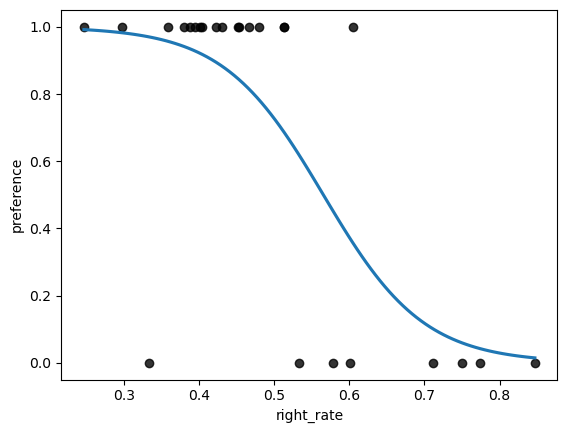

In [46]:
import seaborn as sns

x = data_training['right_rate']
y = data_training['preference']

sns.regplot(x=x, y=y, data=data, logistic = True, ci = None, scatter_kws={'color':'black'})